In [1]:
%pylab inline
try:
    reload(galpy.df_src.streamgapdf)
    reload(galpy.df_src.streamgapdf.galpy.df_src.streamdf)
except NameError:
    import galpy.df_src.streamgapdf
import os, os.path
from scipy import interpolate
from galpy.orbit import Orbit
from galpy.potential import LogarithmicHaloPotential
from galpy.actionAngle import actionAngleIsochroneApprox, estimateBIsochrone
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_coords, bovy_conversion #for unit conversions

Populating the interactive namespace from numpy and matplotlib


# A *galpy* model of the gap in Denis' simulation

# Modeling the unperturbed stream

The background potential

In [2]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)

We'll normalize positions and velocities using the following scales:

In [3]:
R0, V0= 8., 220.

Quick function to convert a snapshot to cylindrical coordinates

In [4]:
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out

We start from the progenitor's original position integrated forward in time to figure out the current phase-space position

In [5]:
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]

In [6]:
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]],ro=R0,vo=V0)
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),1001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1])[0],prog_init.y(times[-1])[0],prog_init.z(times[-1]),
              prog_init.vx(times[-1])[0],prog_init.vy(times[-1])[0],prog_init.vz(times[-1])]

Now we load the current snapshot and sort it by particle ID for later

In [7]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_unperturbed.txt'))
xv_unp_peri= xvid[:,:6]
xv_unp_peri= xv_unp_peri[numpy.argsort(xvid[:,6])]

Let's compare the median of the snapshot to the current position of the progenitor that we calculated above

In [8]:
print numpy.median(xv_unp_peri,axis=0), xv_unp_peri_prog

[  20.617455     5.039721   -16.088234    11.298809   156.243179
  -72.4251975] [20.624926997104502, 5.0950045522192191, -16.114716519179737, 10.828156330627257, 156.49209358413074, -72.022229017296226]


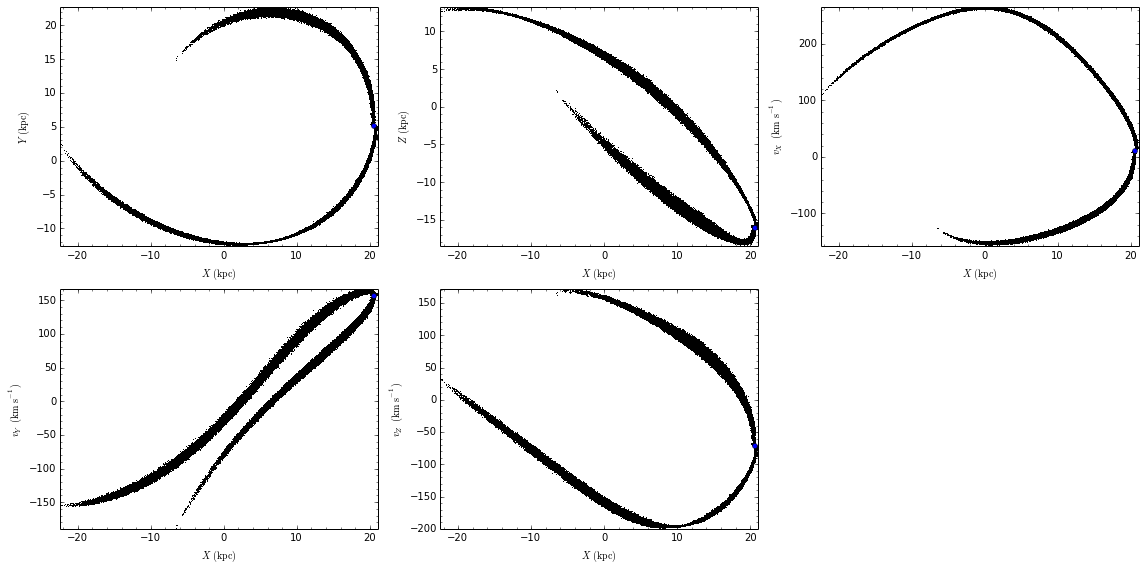

In [9]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,1],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[1],'bo',ms=5.,overplot=True)
subplot(2,3,2)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,2],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[2],'bo',ms=5.,overplot=True)
subplot(2,3,3)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,3],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_X\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[3],'bo',ms=5.,overplot=True)
subplot(2,3,4)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,4],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[4],'bo',ms=5.,overplot=True)
subplot(2,3,5)
bovy_plot.bovy_plot(xv_unp_peri[:,0],xv_unp_peri[:,5],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_unp_peri_prog[0],xv_unp_peri_prog[5],'bo',ms=5.,overplot=True)
tight_layout()

In [10]:
RvR_unp_peri= convert_to_cylindrical(xv_unp_peri)
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]

Snapshot plots in cylindrical coordinates

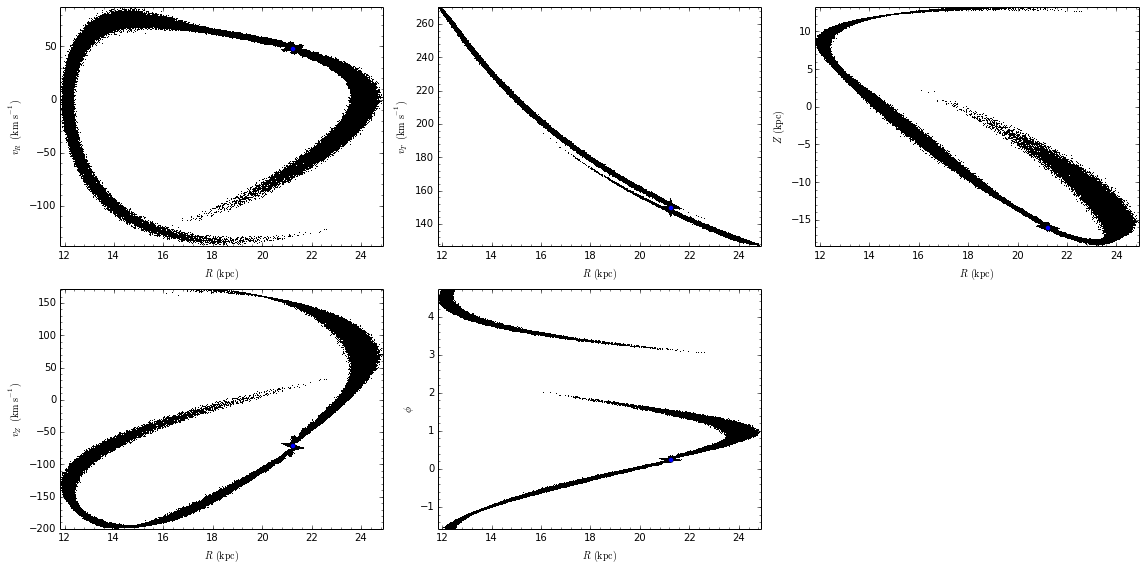

In [11]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,1],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_R\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],'bo',ms=5.,overplot=True)
subplot(2,3,2)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,2],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_T\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[2],'bo',ms=5.,overplot=True)
subplot(2,3,3)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,3],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[3],'bo',ms=5.,overplot=True)
subplot(2,3,4)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,4],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[4],'bo',ms=5.,overplot=True)
subplot(2,3,5)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,5],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$\phi$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[5],'bo',ms=5.,overplot=True)
tight_layout()

Now we setup a *galpy* model for the unperturbed stream

In [12]:
prog_unp_peri= Orbit([RvR_unp_peri_prog[0]/R0,RvR_unp_peri_prog[1]/V0,RvR_unp_peri_prog[2]/V0,
                      RvR_unp_peri_prog[3]/R0+0.0,RvR_unp_peri_prog[4]/V0,RvR_unp_peri_prog[5]]) # Normalized coordinates

We'll integrate this orbit to find a good isochrone auxiliary potential for the action-angle driver

In [13]:
ts= numpy.linspace(0.,100.,1001)
prog_unp_peri.integrate(ts,lp)
estimateBIsochrone(prog_unp_peri.R(ts),prog_unp_peri.z(ts),pot=lp)

(0.75649266398566906, 1.3897492117801131, 1.7096377875748467)

In [14]:
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)

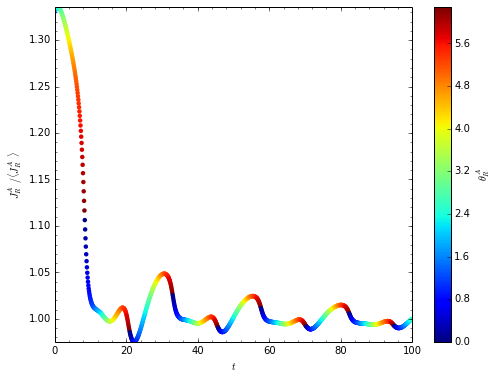

In [15]:
figsize(8,6)
aAI.plot(prog_unp_peri,type='jr')

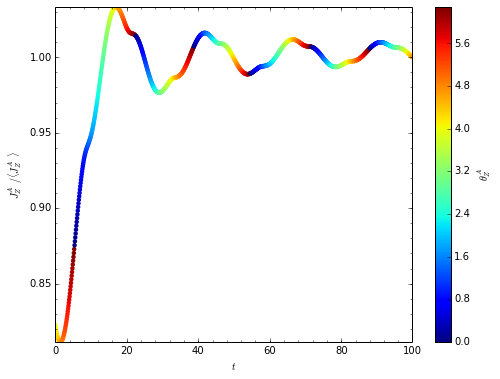

In [16]:
figsize(8,6)
aAI.plot(prog_unp_peri,type='jz')

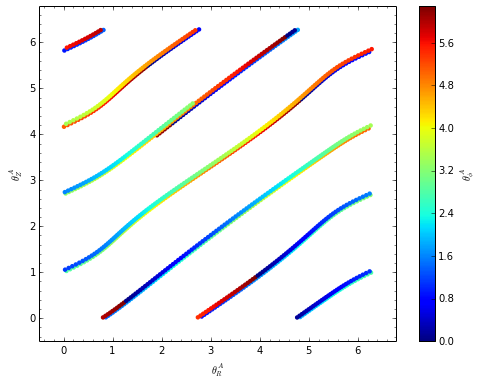

In [17]:
figsize(8,6)
aAI.plot(prog_unp_peri,type='araz')

In [18]:
sigv= 0.365*(10./2.)**(1./3.) # km/s, based on M^(1/3) scaling applied to 10^5 vs. 2x10^4 in my paper

In [19]:
sdfl_unp_peri= streamdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                        leading=False,nTrackChunks=26,nTrackIterations=1,
                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                        Vnorm=V0,Rnorm=R0)

Check the calculation of the stream track:

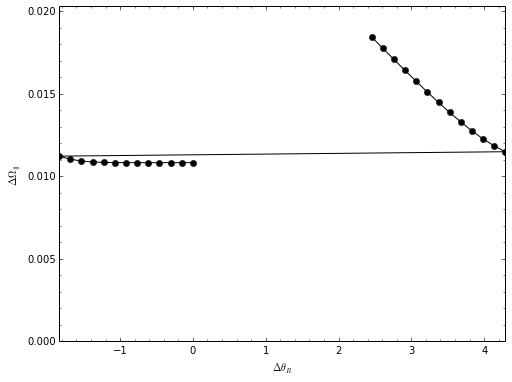

In [20]:
figsize(8,6)
sdfl_unp_peri.plotCompareTrackAAModel()

Stream track vs. the simulation:

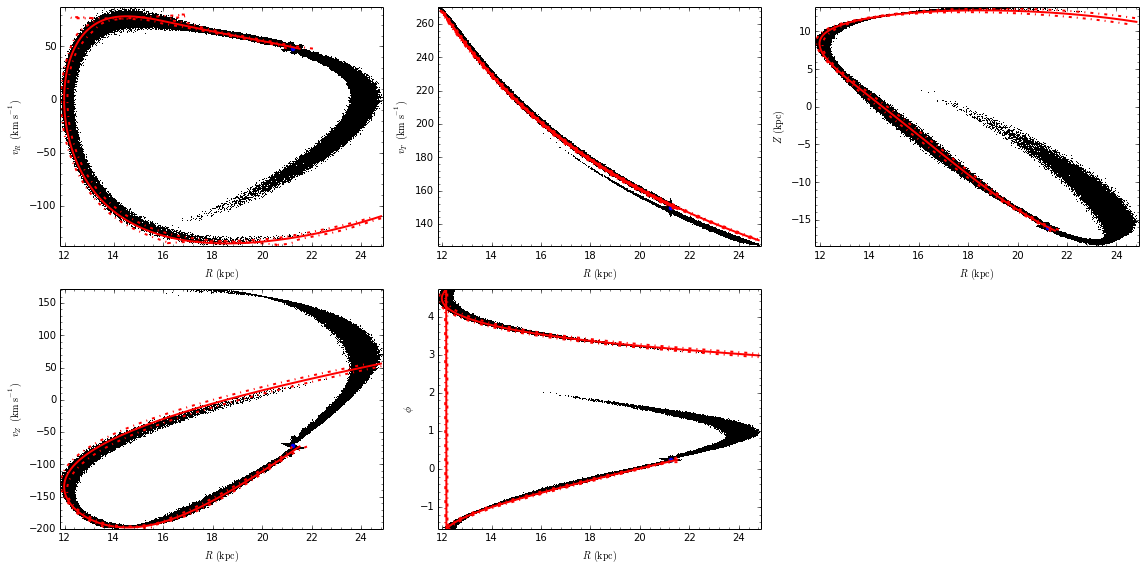

In [21]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,1],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_R\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='vR',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,2)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,2],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_T\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[2],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='vT',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,3)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,3],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[3],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='Z',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,4)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,4],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[4],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='vZ',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,5)
bovy_plot.bovy_plot(RvR_unp_peri[:,0],RvR_unp_peri[:,5],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$\phi$',gcf=True)
bovy_plot.bovy_plot(RvR_unp_peri_prog[0],RvR_unp_peri_prog[5],'bo',ms=5.,overplot=True)
sdfl_unp_peri.plotTrack(d1='R',d2='phi',interp=True,color='r',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
tight_layout()

That looks pretty good! Remember that we only modeled the leading stream...

## Modeling the perturbed stream

We will now build a model of the perturbed stream, starting from the model for the unperturbed stream. First we read Denis' file with the point of closest approach, to figure out the angle difference between the progenitor at this point

In [22]:
xv_impact= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','gap_location_impact.txt'))[:6]
RvR_impact= convert_to_cylindrical(xv_impact[:,numpy.newaxis].T)[0,:]
xv_gap= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','gap_location_2nd_peri.txt'))[:6]
RvR_gap= convert_to_cylindrical(xv_gap[:,numpy.newaxis].T)[0,:]

In [23]:
aA_impact= aAI.actionsFreqsAngles(RvR_impact[0]/R0,RvR_impact[1]/V0,RvR_impact[2]/V0,
                                  RvR_impact[3]/R0+10.**-4.,RvR_impact[4]/V0,RvR_impact[5]) # HACK for zero Jz

The angle difference wrt the progenitor at the time of impact is

In [24]:
dar= aA_impact[6]-(sdfl_unp_peri._progenitor_angler-sdfl_unp_peri._progenitor_Omegar*0.88/bovy_conversion.time_in_Gyr(V0,R0))-4.*numpy.pi
daphi= aA_impact[7]-(sdfl_unp_peri._progenitor_anglephi-sdfl_unp_peri._progenitor_Omegaphi*0.88/bovy_conversion.time_in_Gyr(V0,R0))-2.*numpy.pi
daz= aA_impact[8]-(sdfl_unp_peri._progenitor_anglez-sdfl_unp_peri._progenitor_Omegaz*0.88/bovy_conversion.time_in_Gyr(V0,R0))-4.*numpy.pi
daperp= numpy.dot(numpy.array([dar[0],daphi[0],daz[0]]),sdfl_unp_peri._dsigomeanProgDirection)
print "angle offset from progenitor is %f" % (-daperp)

angle offset from progenitor is -2.349189


Alternatively, we can start from the progenitor at impact. First we load the unperturbed stream at impact

In [25]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_impact_unperturbed.txt'))
xv_unp_impact= xvid[:,:6]
RvR_unp_impact= convert_to_cylindrical(xv_unp_impact)

The progenitor is then

In [26]:
xv_unp_impact_prog= numpy.median(xv_unp_impact,axis=0)
RvR_impact_prog= convert_to_cylindrical(xv_unp_impact_prog[:,numpy.newaxis].T)[0,:]
aA_impact_prog= aAI.actionsFreqsAngles(RvR_impact_prog[0]/R0,RvR_impact_prog[1]/V0,RvR_impact_prog[2]/V0,
                                  RvR_impact_prog[3]/R0+10.**-4.,RvR_impact_prog[4]/V0,RvR_impact_prog[5]) # HACK for zero Jz

In [27]:
dar= aA_impact[6]-aA_impact_prog[6]
daphi= aA_impact[7]-aA_impact_prog[7]
daz= aA_impact[8]-aA_impact_prog[8]-2.*numpy.pi
daperp= numpy.dot(numpy.array([dar[0],daphi[0],daz[0]]),sdfl_unp_peri._dsigomeanProgDirection)
print "angle offset from progenitor is %f" % (-daperp)

angle offset from progenitor is -2.342917


Now we set up a model for the $M = 10^8\,M_\odot$ impact

In [28]:
try:
    reload(galpy.df_src.streamgapdf)
    reload(galpy.df_src.streamgapdf.galpy.df_src.streamdf)
except NameError:
    import galpy.df_src.streamgapdf

In [29]:
sdfl_per_1e8_peri= galpy.df_src.streamgapdf.streamgapdf(sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
                                                        leading=False,nTrackChunks=26,nTrackIterations=1,
                                                        tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
                                                        Vnorm=V0,Rnorm=R0,
                                                        impactb=0.,
                                                        subhalovel=numpy.array([6.82200571,132.7700529,149.4174464])/V0, # from Denis' email
                                                        timpact=0.88/bovy_conversion.time_in_Gyr(V0,R0),
                                                        impact_angle=-2.34,
                                                        GM=10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
                                                        rs=0.625/R0)                                 

Check the calculation of the track

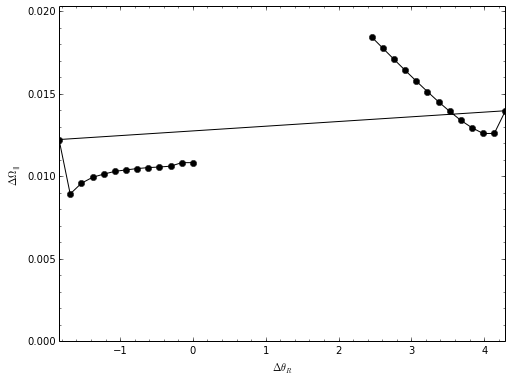

In [30]:
figsize(8,6)
sdfl_per_1e8_peri.plotCompareTrackAAModel()

Now we're going into the development zone, so we'll just start using the private attributes of the streamgapdf object. The track near the impact is

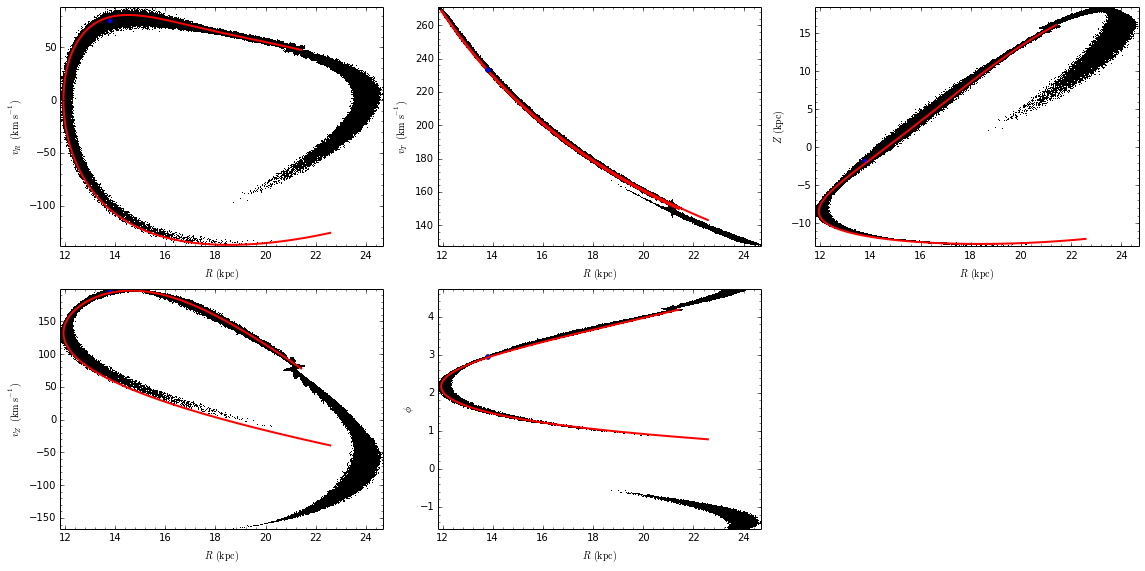

In [31]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,1],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_R\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[1],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,1]*V0,
     'r-',lw=2.)
subplot(2,3,2)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,2],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_T\,(\mathrm{km\,s}^{-1})$',gcf=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,2]*V0,
     'r-',lw=2.)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[2],'bo',ms=5.,overplot=True)
subplot(2,3,3)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,3],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[3],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,3]*R0,
     'r-',lw=2.)
subplot(2,3,4)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,4],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[4],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,4]*V0,
     'r-',lw=2.)

subplot(2,3,5)
bovy_plot.bovy_plot(RvR_unp_impact[:,0],RvR_unp_impact[:,5],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$\phi$',gcf=True)
bovy_plot.bovy_plot(RvR_impact[0],RvR_impact[5],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrack[:,5],
     'r-',lw=2.)

tight_layout()

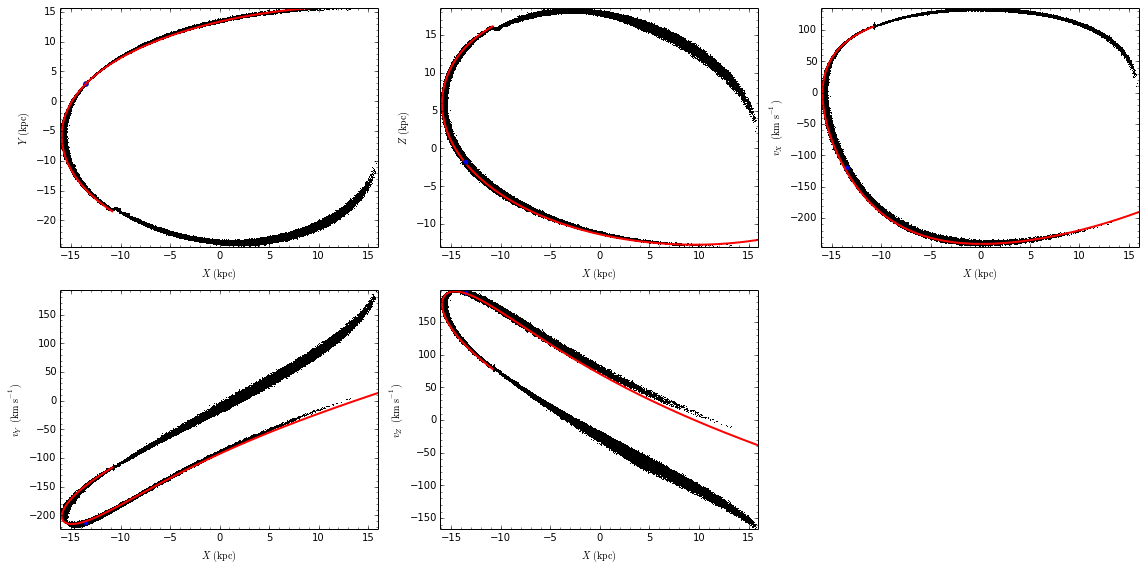

In [32]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,1],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',gcf=True)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[1],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,1]*R0,
     'r-',lw=2.)
subplot(2,3,2)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,2],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,2]*R0,
     'r-',lw=2.)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[2],'bo',ms=5.,overplot=True)
subplot(2,3,3)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,3],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_X\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[3],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,3]*V0,
     'r-',lw=2.)
subplot(2,3,4)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,4],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[4],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,4]*V0,
     'r-',lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(xv_unp_impact[:,0],xv_unp_impact[:,5],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True)
bovy_plot.bovy_plot(xv_impact[0],xv_impact[5],'bo',ms=5.,overplot=True)
plot(sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,0]*R0,sdfl_per_1e8_peri._kick_interpolatedObsTrackXY[:,5]*V0,
     'r-',lw=2.)
tight_layout()

That looks okay. Let's look at the velocity kicks

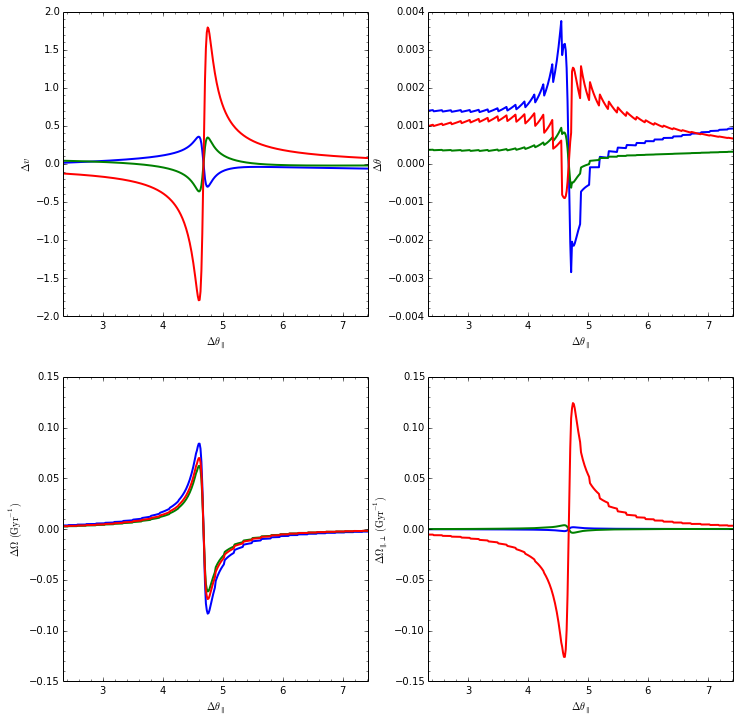

In [33]:
figsize(12,12)
subplot(2,2,1)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack+sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_deltav*V0,'-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta v$',
                    yrange=[-2.,2.],gcf=True)
subplot(2,2,2)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack+sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_dOap[:,3:],'-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \theta$',
                    yrange=[-0.004,0.004],gcf=True)
subplot(2,2,3)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack+sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_dOap[:,:3]*bovy_conversion.freq_in_Gyr(V0,R0),'-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Omega\,(\mathrm{Gyr}^{-1})$',
                    yrange=[-0.15,0.15],gcf=True)
subplot(2,2,4)
bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack+sdfl_per_1e8_peri._impact_angle,
                    sdfl_per_1e8_peri._kick_dOaparperp*bovy_conversion.freq_in_Gyr(V0,R0),'-',lw=2.,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Omega_{\parallel,\perp}\,(\mathrm{Gyr}^{-1})$',
                    yrange=[-0.15,0.15],gcf=True)
#bovy_plot.bovy_plot(sdfl_per_1e8_peri._kick_interpolatedThetasTrack+sdfl_per_1e8_peri._impact_angle,
#                    sdfl_per_1e8_peri._kick_interpdOpar(sdfl_per_1e8_peri._kick_interpolatedThetasTrack)*bovy_conversion.freq_in_Gyr(V0,R0),'-',lw=2.,
#                    overplot=True)

The rewound angles are different from backwards linear evolution at the mean frequency offset by the following amount:

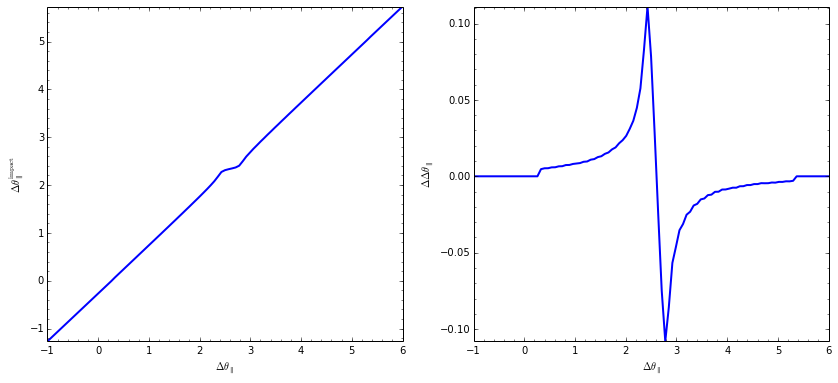

In [34]:
figsize(14,6)
subplot(1,2,1)
xs= numpy.linspace(-1.,6.,101)
bovy_plot.bovy_plot(xs,
                    [sdfl_per_1e8_peri._rewind_angle_impact(x) for x in xs],
                    '-',lw=2.,gcf=True,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \theta_\parallel^\mathrm{impact}$')
subplot(1,2,2)
bovy_plot.bovy_plot(xs,
                    [sdfl_per_1e8_peri._rewind_angle_impact(x)+sdfl_per_1e8_peri._meandO*sdfl_per_1e8_peri._timpact*sdfl_per_1e8_peri._sigMeanSign-x for x in xs],
                    '-',lw=2.,gcf=True,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Delta \theta_\parallel$')

The mean frequency offset as a function of position along the stream is (compared to the unperturbed case)

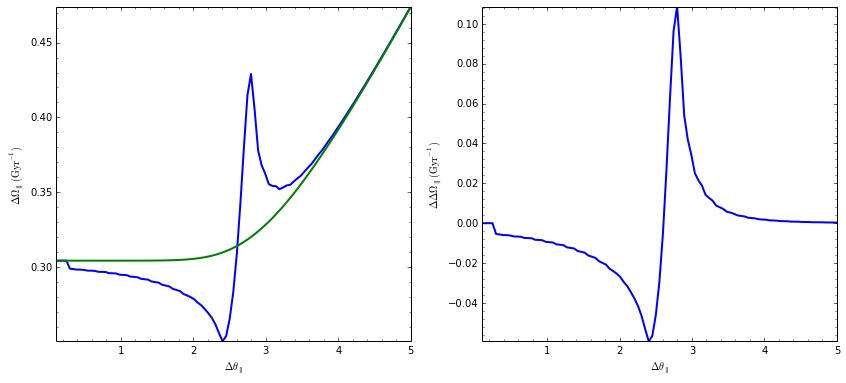

In [35]:
figsize(14,6)
subplot(1,2,1)
xs= numpy.linspace(0.1,5.,101)
bovy_plot.bovy_plot(xs,
                    [sdfl_per_1e8_peri.meanOmega(x,oned=True)*bovy_conversion.freq_in_Gyr(V0,R0) for x in xs],
                    '-',lw=2.,gcf=True,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Omega_\parallel\,(\mathrm{Gyr}^{-1})$')
bovy_plot.bovy_plot(xs,
                    [super(galpy.df_src.streamgapdf.streamgapdf,sdfl_per_1e8_peri).meanOmega(x,oned=True)*bovy_conversion.freq_in_Gyr(V0,R0) for x in xs],
                    '-',lw=2.,overplot=True)
subplot(1,2,2)
bovy_plot.bovy_plot(xs,
                    [sdfl_per_1e8_peri.meanOmega(x,oned=True)*bovy_conversion.freq_in_Gyr(V0,R0)-super(galpy.df_src.streamgapdf.streamgapdf,sdfl_per_1e8_peri).meanOmega(x,oned=True)*bovy_conversion.freq_in_Gyr(V0,R0) for x in xs],
                    '-',lw=2.,gcf=True,
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Delta \Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

Frequencies in $R$, $\phi$, and $Z$ compared to the unperturbed case look like this

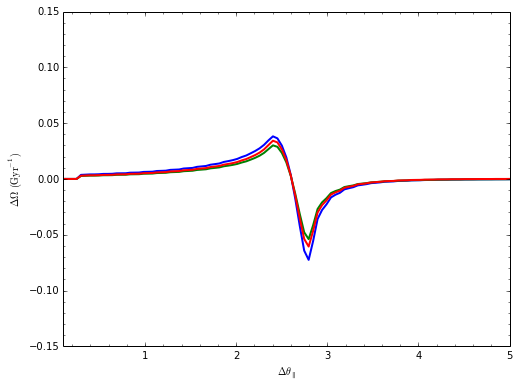

In [36]:
figsize(8,6)
xs= numpy.linspace(0.1,5.,101)
bovy_plot.bovy_plot(xs,
                    [(sdfl_per_1e8_peri.meanOmega(x)-super(galpy.df_src.streamgapdf.streamgapdf,sdfl_per_1e8_peri).meanOmega(x))*bovy_conversion.freq_in_Gyr(V0,R0) for x in xs],
                    '-',lw=2.,
                    yrange=[-0.15,0.15],
                    xlabel=r'$\Delta \theta_\parallel$',ylabel=r'$\Delta \Omega\,(\mathrm{Gyr}^{-1})$')

Now we load the perturbed simulation

In [37]:
xvid= numpy.loadtxt(os.path.join(os.getenv('DATADIR'),'streamgap-aa','nonzeroJz','snapshot_2nd_peri_1e8.txt'))
xv_1e8_peri= xvid[:,:6]
xv_1e8_peri= xv_1e8_peri[numpy.argsort(xvid[:,6])]
RvR_1e8_peri= convert_to_cylindrical(xv_1e8_peri)

In [38]:
print RvR_gap

[  13.15128832   64.62548929  244.63114338    3.469929   -188.48819
   -1.20285433]


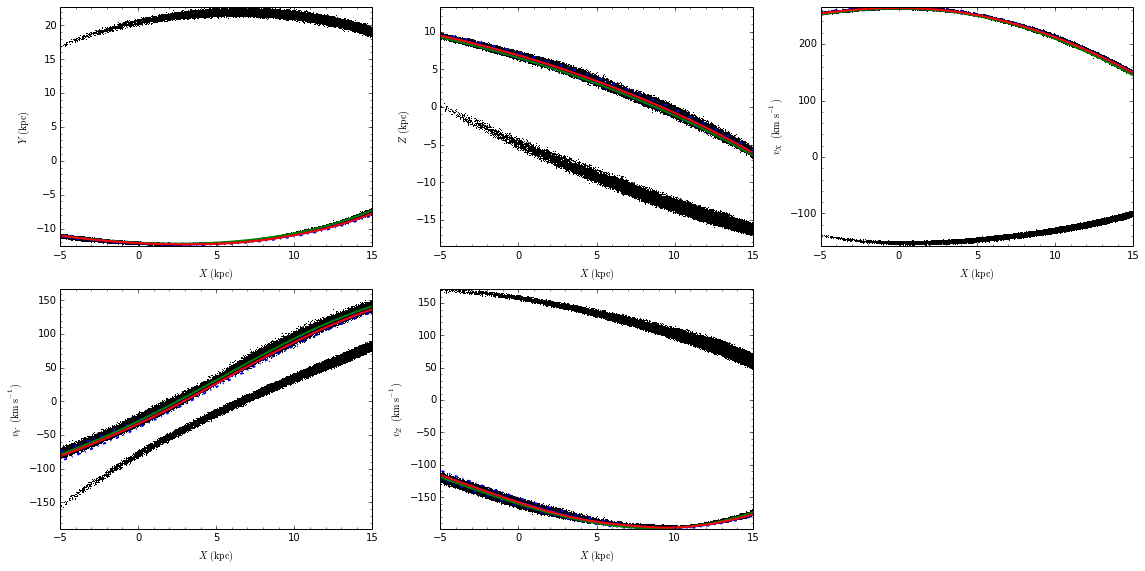

In [39]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,1],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='Y',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='Y',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='Y',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,2)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,2],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='Z',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='Z',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='Z',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,3)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,3],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_X\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='vX',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='vX',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='vX',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,4)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,4],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='vY',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='vY',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='vY',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,5)
bovy_plot.bovy_plot(xv_1e8_peri[:,0],xv_1e8_peri[:,5],'k,',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[-5.,15.])
sdfl_unp_peri.plotTrack(d1='X',d2='vZ',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='X',d2='vZ',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='X',d2='vZ',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
tight_layout()

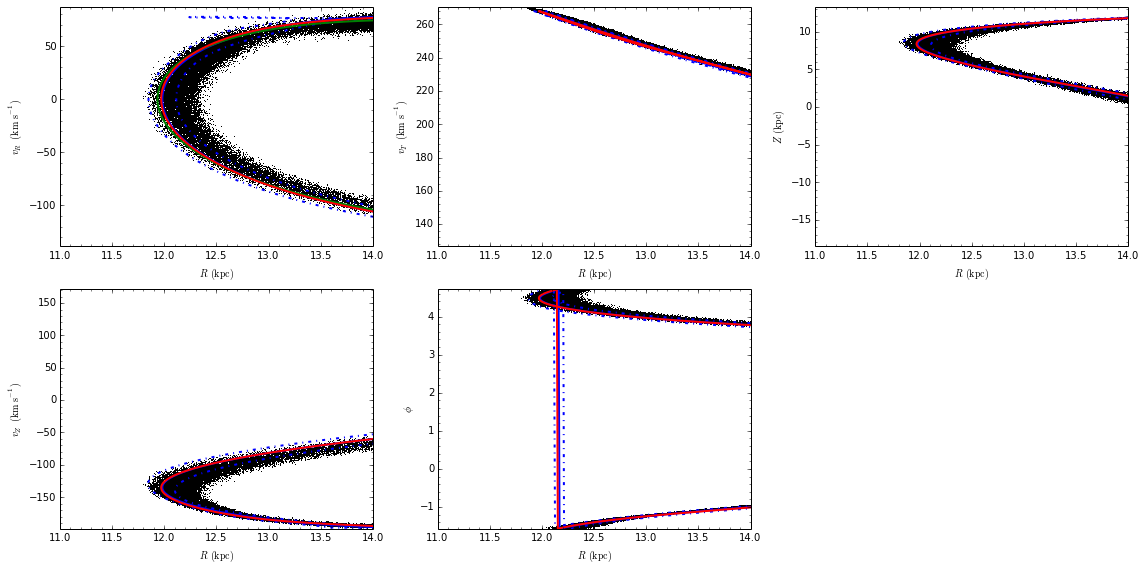

In [40]:
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,1],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_R\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='vR',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_unp_peri.plotProgenitor(d1='R',d2='vR',color='g',overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='vR',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,2)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,2],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_T\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='vT',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='vT',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,3)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,3],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='Z',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='Z',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,4)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,4],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='vZ',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='vZ',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
subplot(2,3,5)
bovy_plot.bovy_plot(RvR_1e8_peri[:,0],RvR_1e8_peri[:,5],'k,',xlabel=r'$R\,(\mathrm{kpc})$',
                    ylabel=r'$\phi$',gcf=True,
                    xrange=[11.,14.])
sdfl_unp_peri.plotTrack(d1='R',d2='phi',interp=True,color='b',spread=2,overplot=True,lw=2.,scaleToPhysical=True)
sdfl_per_1e8_peri.plotTrack(d1='R',d2='phi',interp=True,color='r',spread=0,overplot=True,lw=2.,scaleToPhysical=True)
tight_layout()

Now we calculate the density near the gap in the perturbed and unperturbed case and compare it to the simulations. We compute the density from the model by sampling a large number of points from the model:

In [41]:
xrange=[-5.,15.]
numpy.random.seed(1)
xv_mock_per= sdfl_per_1e8_peri.sample(n=100000,xy=True).T
b,e= numpy.histogram(xv_mock_per[xv_mock_per[:,1]*8. < 5.,0]*8.,bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xs_per= numpy.linspace(t[0],t[-1],1001)
xps_per= numpy.exp(lspl(xs_per))
xps_per/= numpy.nansum(xps_per)*(xs_per[1]-xs_per[0])

In [42]:
numpy.random.seed(1) # Same seed, such that the mocks are the same, except for the kick
xv_mock_unp= sdfl_unp_peri.sample(n=100000,xy=True).T
b,e= numpy.histogram(xv_mock_unp[xv_mock_unp[:,1]*8. < 5.,0]*8.,bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xs_unp= numpy.linspace(t[0],t[-1],1001)
xps_unp= numpy.exp(lspl(xs_unp))
xps_unp/= numpy.nansum(xps_unp)*(xs_unp[1]-xs_unp[0])

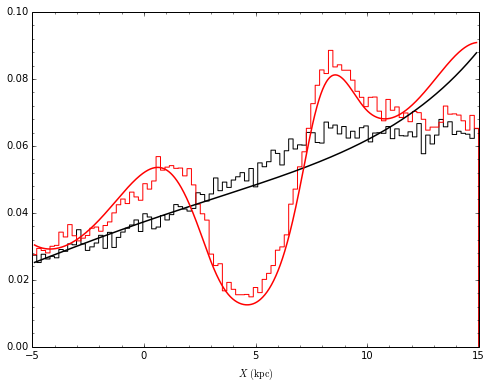

In [43]:
figsize(8,6)
raw= bovy_plot.bovy_hist(xv_unp_peri[xv_unp_peri[:,1] < 5.,0],bins=101,fc='0.5',ec='k',normed=True,histtype='step',
                         yrange=[0.,0.1],range=xrange,xlabel=r'$X\,(\mathrm{kpc})$')
raw= bovy_plot.bovy_hist(xv_1e8_peri[xv_1e8_peri[:,1] < 5.,0],bins=101,fc='0.5',ec='r',normed=True,histtype='step',
                         overplot=True,range=xrange)
bovy_plot.bovy_plot(xs_unp,xps_unp,'k-',lw=1.5,overplot=True)
bovy_plot.bovy_plot(xs_per,xps_per,'r-',lw=1.5,overplot=True)
#raw= bovy_plot.bovy_hist(xv_mock_unp[xv_mock_unp[:,1]*8. < 5.,0]*8.,bins=101,fc='0.5',ec='b',normed=True,histtype='step',
#                         overplot=True,range=[-5.,15.])

That looks good. How do we do relatively?

In [44]:
b,e= numpy.histogram(xv_1e8_peri[xv_1e8_peri[:,1] < 5.,0],bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xs_per_data= numpy.linspace(t[0],t[-1],1001)
xps_per_data= numpy.exp(lspl(xs_per_data))
xps_per_data/= numpy.nansum(xps_per)*(xs_per_data[1]-xs_per_data[0])
b,e= numpy.histogram(xv_unp_peri[xv_unp_peri[:,1] < 5.,0],bins=101,normed=True,range=xrange)
t= ((numpy.roll(e,1)-e)/2.+e)[1:]
lspl= interpolate.UnivariateSpline(t,numpy.log(b),k=3,s=1.)
xps_unp_data= numpy.exp(lspl(xs_per_data))
xps_unp_data/= numpy.nansum(xps_unp_data)*(xs_per_data[1]-xs_per_data[0])

<Container object of 1001 artists>

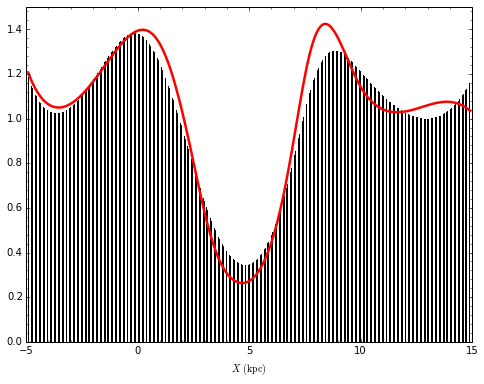

In [45]:
figsize(8,6)
bovy_plot.bovy_plot(xs_per,xps_per/xps_unp,'r-',lw=2.5,zorder=1,
                    yrange=[0.,1.5],xrange=xrange,xlabel=r'$X\,(\mathrm{kpc})$')
#bovy_plot.bovy_plot(xs_per_data,xps_per_data/xps_unp_data,'k-',lw=1.5,overplot=True)
bar(xs_per_data-(xs_per_data[1]-xs_per_data[0])/2.,xps_per_data/xps_unp_data,width=(xs_per_data[1]-xs_per_data[0])/2.,
    bottom=0.,ec='none',color='k',zorder=0)

Let's look at phase-space *differences*:

In [46]:
# Subsample to lower the density
subIndx= numpy.random.permutation(len(xv_mock_per))[:len(xv_mock_per)//10]
xv_mock_per= xv_mock_per[subIndx]
xv_mock_unp= xv_mock_unp[subIndx]

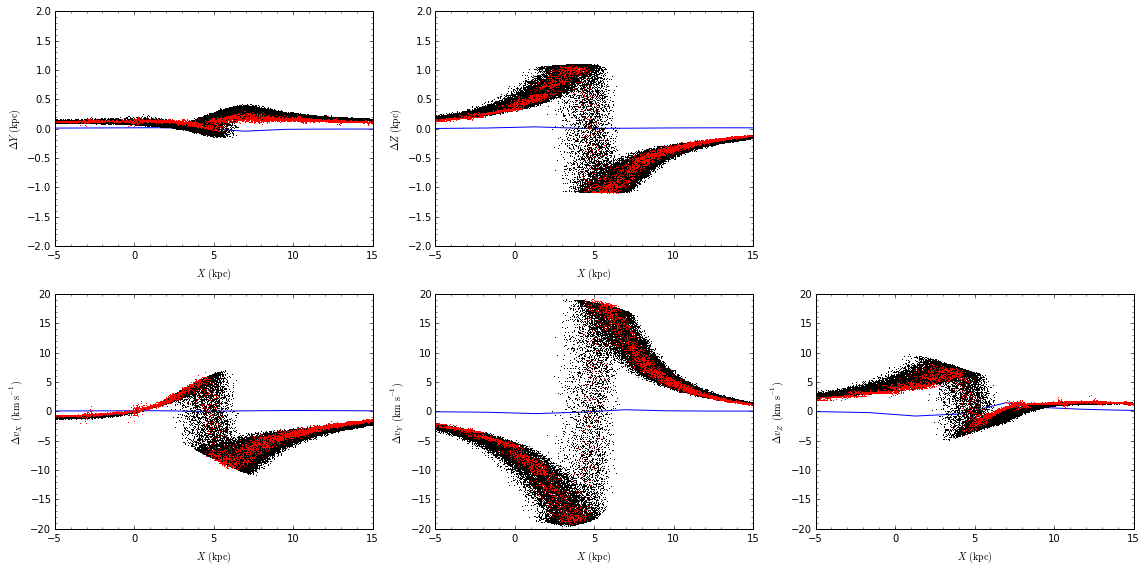

In [47]:
xs= numpy.linspace(-5.,15.,1001)
figsize(16,8)
subplot(2,3,1)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,1]-sdfl_unp_peri._ObsTrackXY[:,1])*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta Y\,(\mathrm{kpc})$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),1]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),1],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,1]-xv_mock_unp[:,1])*R0,'r,')
subplot(2,3,2)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,2]-sdfl_unp_peri._ObsTrackXY[:,2])*R0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta Z\,(\mathrm{kpc})$',gcf=True,yrange=[-2.,2.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),2]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),2],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,2]-xv_mock_unp[:,2])*R0,'r,')
subplot(2,3,4)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,3]-sdfl_unp_peri._ObsTrackXY[:,3])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_X\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),3]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),3],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,3]-xv_mock_unp[:,3])*V0,'r,')
subplot(2,3,5)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,4]-sdfl_unp_peri._ObsTrackXY[:,4])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_Y\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),4]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),4],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,4]-xv_mock_unp[:,4])*V0,'r,')
subplot(2,3,6)
bovy_plot.bovy_plot(sdfl_unp_peri._ObsTrackXY[:,0]*R0,
                    (sdfl_per_1e8_peri._ObsTrackXY[:,5]-sdfl_unp_peri._ObsTrackXY[:,5])*V0,
                    'b-',xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$\Delta v_Z\,(\mathrm{km\,s}^{-1})$',gcf=True,yrange=[-20.,20.],
                   xrange=[-5.,15.])
plot(xv_unp_peri[(xv_unp_peri[:,1] < 5.),0],xv_1e8_peri[(xv_unp_peri[:,1] < 5.),5]-xv_unp_peri[(xv_unp_peri[:,1] < 5.),5],'k,')
plot(xv_mock_unp[:,0]*R0,(xv_mock_per[:,5]-xv_mock_unp[:,5])*V0,'r,')
tight_layout()